In [367]:
import pandas as pd
import numpy as np
import scipy
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from scipy import stats
init_notebook_mode(connected=True)
%matplotlib inline

Найди все интересные на твой взгляд инсайты и представь их в любом удобном виде.

Обозначения:

- id - ... (очевидно)
- created_at - Дата принятия заказа Инстамартом (пользователь собрал корзину и сделал заказ)
- city - ...
- lat - ...
- lon - ...
- item_total - Сумма позиций в доставке
- cost - Первоначальная стоимость доставки
- retailer_id - ...
- user_id - ....
- total_cost - Стоимость доставки после применения промокода на скидку к доставке (если промокода не было, то cost=total_cost)
- promo_total - Промокод на сумму позиций (скидка непосредственно примененная к товарам)
- total_weight - Вес заказа , г.
- total_quantity - Количество единиц товара
- state - состояние доставки
- shipped_at - Дата доставки заказа
- store_id - ...

Инсайты:
    
- В половине случаев не заполняется время отправки
- В 30% случаев не заполняется user id

In [161]:
data = pd.read_csv('Instamart_data.csv')

In [162]:
data.head()

,id,created_at,city,lat,lon,item_total,cost,retailer_id,user_id,total_cost,promo_total,total_weight,total_quantity,state,shipped_at,store_id
0,0,2018-08-02 00:01:00,1,55.834381,37.530174,1679,199.0,9,81434.0,190.0,0.0,9745,30,shipped,2018-08-02 08:39:00,30
1,1,2018-08-02 00:09:00,1,55.776063,37.535981,698,299.0,1,NaN,0.0,0.0,500,2,pending,NaN,14
2,2,2018-08-02 00:23:00,1,55.703454,37.467994,1444,299.0,1,30278.0,299.0,0.0,9460,14,canceled,NaN,17
3,3,2018-08-02 00:26:00,1,55.761914,37.565010,1524,299.0,1,103825.0,299.0,0.0,8230,17,shipped,2018-08-07 08:21:00,24
4,4,2018-08-02 00:32:00,1,55.811434,37.496868,9608,299.0,1,9786.0,596.0,0.0,50139,77,shipped,2018-08-02 13:53:00,13


In [163]:
print('NAN in columns: ')
for column in data.columns:
    if any(data[column].isna()):
        
        print(column + ' ' + str(data[column].isna().value_counts()[1]))

NAN in columns: 
lat 22
lon 22
user_id 95745
shipped_at 166670


In [164]:
# Добавим флажок для строк, где было применение купона

data['promo_flag'] = (data['cost'] != data['total_cost']).astype('int')

# Исключим из фрейма отменные заказы

data = data[data['state'] != 'canceled']

# Исключим строки с суммой покупок равной 0

data = data[data['item_total'] != 0]

In [165]:
# Исключим столбцы с временем

data = data.drop(['created_at', 'shipped_at'], axis=1)

In [166]:
data.fillna(0, inplace=True)

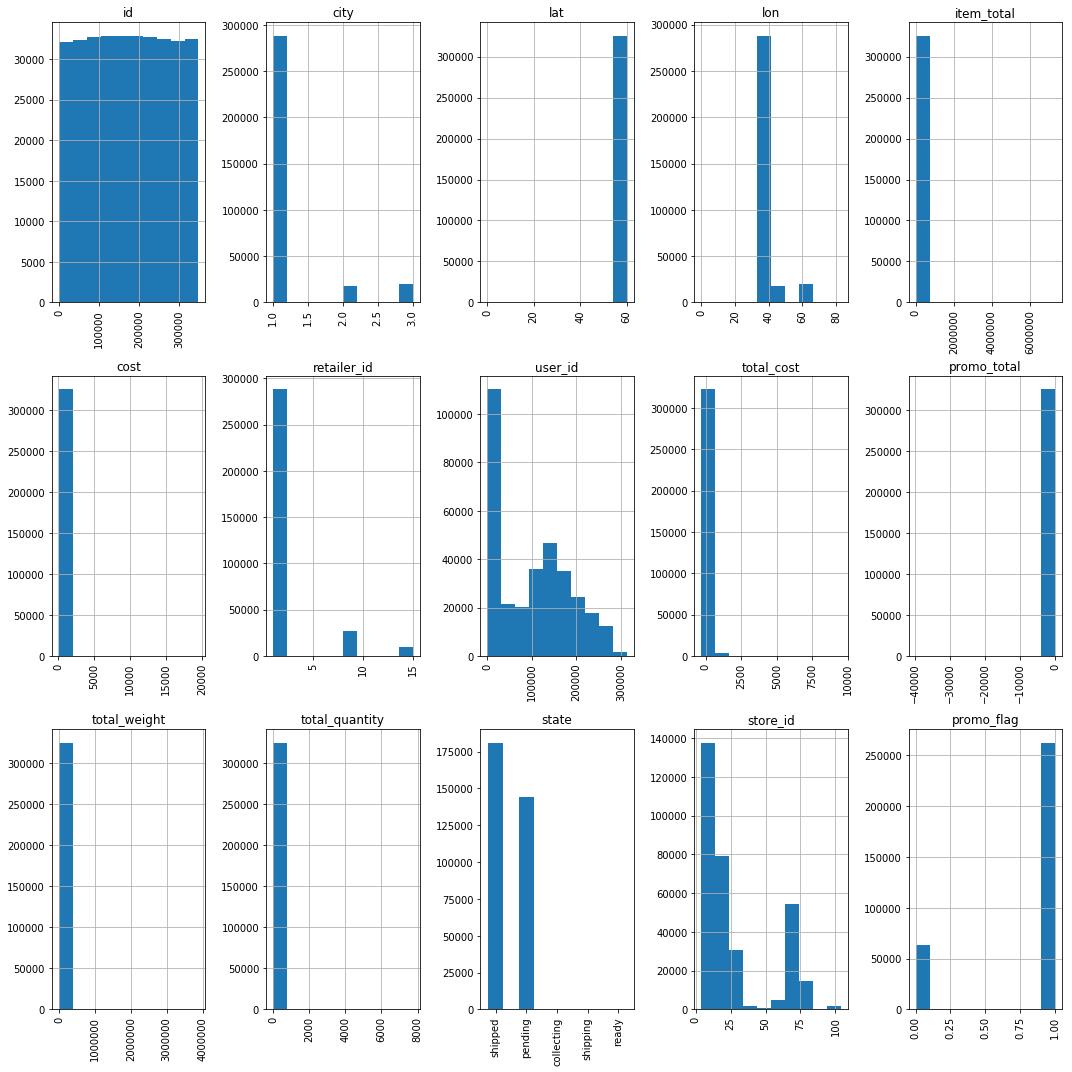

In [119]:
# Посмотрим на распределение показателей 

fig = plt.figure(figsize=(15, 15))
cols = 5
rows = np.ceil(float(data.shape[1]) / cols)
for i, column in enumerate(data[:10].columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == np.object:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.tight_layout()

Исследуем влияние применения промо-купона на поведение юзеров:

In [167]:
data.promo_flag.value_counts()

1    262397
0     63096
Name: promo_flag, dtype: int64

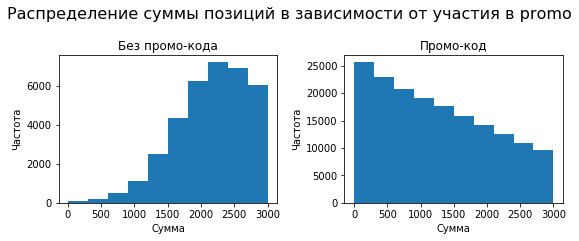

In [247]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(data['item_total'][(data['item_total'] < 3000) & (data['item_total'] > 0000)]\
           [data['promo_flag'] == 0])
axs[0].set_title('Без промо-кода')
axs[0].set_xlabel('Сумма')
axs[0].set_ylabel('Частота')
fig.suptitle('Распределение суммы позиций в зависимости от участия в promo', y = 1.1, fontsize=16)
axs[1].hist(data['item_total'][(data['item_total'] < 3000) & (data['item_total'] > 0000)]\
           [data['promo_flag'] == 1])
axs[1].set_xlabel('Сумма')
axs[1].set_title('Промо-код')
axs[1].set_ylabel('Частота');
fig.tight_layout()
plt.show()

В диапазоне [0, 3000] мы видим, что в категории участников промо-акции плотность распределения преобладает на значениеях близких к нулю и убывает в сторону бОльших значений. 

Предположительно промо-акция привела множество юзеров, совершающих мелкие покупки.

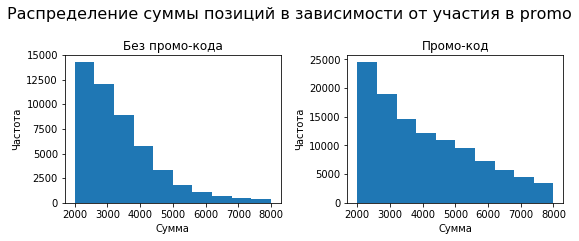

In [248]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 0])
axs[0].set_title('Без промо-кода')
axs[0].set_xlabel('Сумма')
axs[0].set_ylabel('Частота')
fig.suptitle('Распределение суммы позиций в зависимости от участия в promo', y = 1.1, fontsize=16)
axs[1].hist(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 1])
axs[1].set_xlabel('Сумма')
axs[1].set_title('Промо-код')
axs[1].set_ylabel('Частота');
fig.tight_layout()
plt.show()

В тоже время в диапазоне [2000, 8000] для участников промо-акции наблюдается увеличение плотности на учатстках более крупных покупок.

Судя по непропорциональной разнице на графиках можно предположить, что промо-акция скорее привлекает другие категории клиентов нежели заставляет покупать больше имеющиеся.

Посмотрим на распределение количества позиций в заказе:

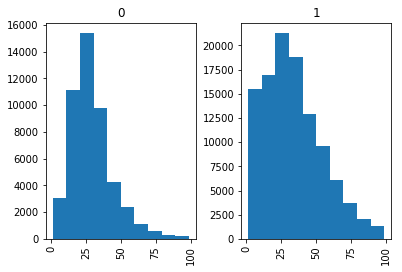

In [259]:
data['total_quantity'][data['total_quantity'] < 100][(data['item_total'] < 8000) & (data['item_total'] > 2000)].hist(by=data['promo_flag']);

В ситуации с промо-акцией наблюдается увеличение плотности на значениях 15 > x > 30

Посчитаем среднюю стоимость заказа отдельно для обычных и промо заказов:

In [264]:
data['item_total'][data['promo_flag'] == 1].mean(), \
data['item_total'][data['promo_flag'] == 0].mean()

(3384.656467108999, 3244.1191676175986)

Хотелось бы получить статистическую значимость полученных наблюдений. Для начала проверим нормальность распределений с помощью критерия Шапиро-Уилка.

Отрежем хвосты, так как мы имеем очень маленькое число очень крупных каказов, которые сильно выбиваются из общего паттерна.

In [360]:
# mu_non_promo = data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 0].mean()
# sigma_non_promo = np.var(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 0])
# size_non_promo = len(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 0])

# mu_promo = data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 1].mean()
# sigma_promo = np.var(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 1])
# size_promo = len(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
#            [data['promo_flag'] == 1])

In [361]:
# expected_frequencies_not_promo = np.random.normal(mu_non_promo, sigma_non_promo, size_non_promo)
# expected_frequencies_promo = np.random.normal(mu_promo, sigma_promo, size_promo)

observed_frequences_not_promo = (data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 0]).values
observed_frequences_promo = (data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 1]).values

In [385]:
print('p-value = ' + str(scipy.stats.shapiro(observed_frequences_promo)[1]))
print('Примечание: для любого размера выборки вероятность ошибки первого рода 5%')

p-value = 0.0
Примечание: для любого размера выборки вероятность ошибки первого рода 5%


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning:

p-value may not be accurate for N > 5000.



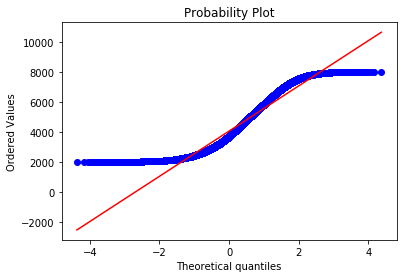

In [386]:
# Посмотрим на QQ-график и убедимся визуально, что распределение сильно отличается от нормального

fig = plt.figure()
ax = fig.add_subplot(111)
scipy.stats.probplot(observed_frequences_promo, plot=ax);

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning:

p-value may not be accurate for N > 5000.



(0.9289239645004272, 0.0)

(array([2790.,   33.,   22.,   18.,   17.,   16.,   14.,   17.,   19.,
          43.]), array([  0.        ,  30.29041237,  60.58082475,  90.87123712,
        121.16164949, 151.45206187, 181.74247424, 212.03288661,
        242.32329899, 272.61371136, 302.90412373]), <a list of 10 Patch objects>)

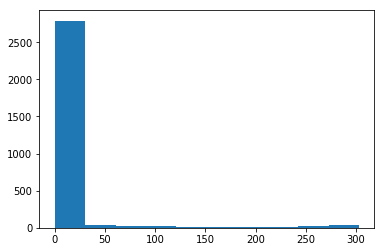

In [300]:
plt.hist([ln*stats.poisson.pmf(x, l) for x in range(mn, mx + 1)])

In [268]:
observed_frequences_non_promo = np.bincount(data['item_total'][data['promo_flag'] == 0])
l = data['item_total'][data['promo_flag'] == 0].mean()
expected_frequences_promo = [len(data['item_total'][data['promo_flag'] == 0])\
                             *stats.poisson.pmf(x, l) for x in range(\
                             min(data['item_total'][data['promo_flag'] == 0]),\
                             max(data['item_total'][data['promo_flag'] == 0]) + 1)]

KeyboardInterrupt: 